# Predicting Tanzania Water Pumps Functionality

**Author : Edwin Maina**



## Business Understanding

Access to clean  water is a fundamental human need and a key for public health, economic development, and social well-being. 

In Tanzania, communities heavily rely on water wells for their daily water supply. However, many of these water points become non-functional over time due to poor maintenance, environmental conditions, or inadequate infrastructure.

This project aims to build a predictive models to assess the functionality status of water wells in Tanzania. The models will help stakeholders prioritize maintenance efforts, allocate resources more effectively, and ensure that water wells remain operational for the communities that depend on them.


### Business Problem

Tanzania's water supply system is characterized by frequent water pump breakdowns resulting from lack of proper maintenance and inefficient management. This leads to disruptions in water supply, exacerbating the acute shortage of clean water and subsequent socio-economic losses.

The government of Tanzania, in collaboration with NGOs and partner organizations, aims to enhance access to clean water by improving the maintenance and functionality of water wells across the country. To achieve this, water point sustainability risk levels across the supply system need to be projected by learning from current point profiles to guide stakeholders' decisions through highlighting:

  - Most dilapidated wells that should be prioritized for maintenance, repairs, or rehabilitation.
  - Sites to be earmarked for future wells.
  - Data-driven recommendations that are responsive to stakeholders' needs and actionable guide improve management practices and water accessibility.


### Importing Required Libraries

In [1]:
# importing pandas for data wrangling and manipulation
import pandas as pd
import numpy as np

# importing matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import random

### loading the Datasets

In [7]:
training_values = pd.read_csv('Trainig_set_values.csv')
training_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
training_labels = pd.read_csv('Training_set_labels.csv')
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [9]:
test_values = pd.read_csv('Test_set_values.csv')
test_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [13]:

# Merging the training values with the labels to create a complete training dataset
train_data = pd.merge(training_values, training_labels, on="id")

train_data.info()

train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


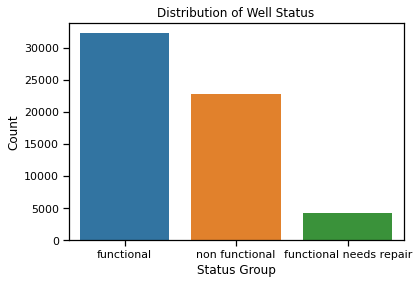

In [11]:
# Checking the distribution of the target variable 'status_group'
target_distribution = train_data['status_group'].value_counts(normalize=True) * 100

# Visualizing the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=train_data, x='status_group', order=train_data['status_group'].value_counts().index, )
plt.title('Distribution of Well Status')
plt.ylabel('Count')
plt.xlabel('Status Group')
plt.show()

In [15]:
# Printing the unique values in each column
{column: train_data[column].nunique() for column in train_data.columns}
    #Observations:

{'id': 59400,
 'amount_tsh': 98,
 'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'installer': 2145,
 'longitude': 57516,
 'latitude': 57517,
 'wpt_name': 37400,
 'num_private': 65,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'region_code': 27,
 'district_code': 20,
 'lga': 125,
 'ward': 2092,
 'population': 1049,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 12,
 'scheme_name': 2696,
 'permit': 2,
 'construction_year': 55,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

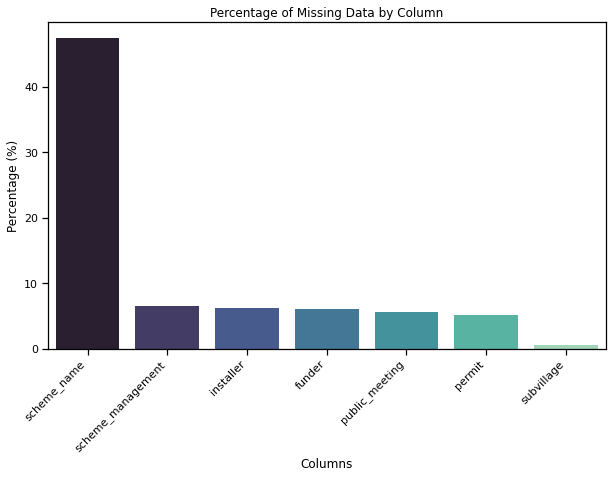

scheme_name          47.417508
scheme_management     6.526936
installer             6.153199
funder                6.119529
public_meeting        5.612795
permit                5.144781
subvillage            0.624579
dtype: float64

In [ ]:
# Checking the percentage of missing values in each column
missing_data = train_data.isnull().mean() * 100

# Filtering columns with missing values only
missing_columns = missing_data[missing_data > 0].sort_values(ascending=False)

# Visualizing 
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_columns.index, y=missing_columns.values, palette='mako')
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

missing_columns
